In [370]:
import numpy as np
from typing import Union, Tuple, Self, Iterable
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import wandb
import time
import psutil

In [371]:
# regular constants
RNG = np.random.default_rng()
DTYPE = 'float32' 

proc  = psutil.Process(os.getpid())

# testing constants
if DTYPE=='float64':
    EPS, ATOL, RTOL = 1e-6, 1e-5, 1e-3
else:
    EPS, ATOL, RTOL = 1e-4, 1e-4, 1e-2
K = 20

dtype_eps = {'float16': 1e-4,
             'float32': 1e-7,
             'float64': 1e-15}[DTYPE]

In [372]:
class Tensor():
    def __init__(self, data, requires_grad=False, children=(), op=''):
        self.data: np.ndarray = np.array(data, dtype=DTYPE)
        self.grad = np.zeros_like(data, dtype=DTYPE)
        self.requires_grad = requires_grad
        self._prev = set(children)
        self._backward = lambda : None
        self._op = op

    @property
    def shape(self) -> Tuple[int]:
        return self.data.shape
    
    @property
    def size(self) -> int: 
        return self.data.size
    
    def zero_grad(self) -> None:
        self.grad = np.zeros_like(self.data, dtype=DTYPE)

    def item(self) -> np.ndarray:
        return self.data
    
    def _unbroadcast(self, grad: np.ndarray) -> Self:
        dims_to_remove = tuple(i for i in range(len(grad.shape) - len(self.shape))) 
        # remove prepended padding dimensions
        grad = np.sum(grad, axis=dims_to_remove, keepdims=False) 
        dims_to_reduce = tuple(i for i, (d1,d2) in enumerate(zip(grad.shape, self.shape)) if d1!=d2)
        # reduce broadcasted dimensions
        return np.sum(grad, axis=dims_to_reduce, keepdims=True)

    # need to build topo graph and then go through it and call backwards on each of the tensors
    def backward(self) -> None:
        self.grad = np.ones_like(self.data)
        topo = []
        visited = set()

        # do DFS on un-visited nodes, add node to topo-when all its children have been visited
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        build_topo(self)

        for node in reversed(topo):
            node._backward()
            node._prev = set(())
            node._backward = lambda : None

    def __getitem__(self, indexes):
        out = Tensor(self.data[indexes], self.requires_grad, (self), 'slice')

        def _backward():
            if self.requires_grad:
                pass
        out._backward = _backward
        return out
            
    def __add__(self, rhs) -> Self:
        rhs = rhs if isinstance(rhs, Tensor) else Tensor(rhs)
        out = Tensor(self.data + rhs.data, self.requires_grad or rhs.requires_grad, (self, rhs), '+')

        def _backward():
            if self.requires_grad:
                self.grad += self._unbroadcast(out.grad)
            if rhs.requires_grad:
                rhs.grad += rhs._unbroadcast(out.grad)
        out._backward = _backward
        return out
    
    def __neg__(self) -> Self:
        out = Tensor(-self.data, self.requires_grad, (self,), 'neg')

        def _backward():
            if self.requires_grad:
                self.grad += -out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, rhs) -> Self:
        return self + (-rhs)

    def __mul__(self, rhs) -> Self:
        rhs = rhs if isinstance(rhs, Tensor) else Tensor(rhs)
        out = Tensor(self.data*rhs.data, self.requires_grad or rhs.requires_grad, (self, rhs), f'*')

        def _backward():
            if self.requires_grad:
                self.grad += self._unbroadcast(out.grad * rhs.data)
            if rhs.requires_grad:
                rhs.grad += rhs._unbroadcast(out.grad * self.data)
        out._backward = _backward
        return out
        
    def __truediv__(self, rhs) -> Self:
        return self * (rhs**-1)
    
    # TODO add check for rhs, if epxponent if negative the gradient is undefined
    def __pow__(self, rhs) -> Self: 
        rhs = rhs if isinstance(rhs, Tensor) else Tensor(rhs)
        lhs_is_neg = self.data < 0
        rhs_is_frac = ~np.isclose(rhs.data % 1, 0)
        if np.any(lhs_is_neg & rhs_is_frac):
            raise ValueError('cannot raise negative value to a decimal power')
        
        out = Tensor(self.data**rhs.data, self.requires_grad or rhs.requires_grad, (self,), f'**')

        def _backward():
            if self.requires_grad:
                self.grad += self._unbroadcast(out.grad * ((rhs.data)*(self.data**(rhs.data-1))))
            if rhs.requires_grad:
                rhs.grad += rhs._unbroadcast(out.grad * (self.data ** rhs.data) * np.log(self.data))
        out._backward = _backward
        return out
    
    '''data shape: (da, ..., d2, d1, n, k) rhs shape: (ob, ..., o2, o1, k, m)
       inputs are broadcast so that they have the same shape by expanding along
       dimensions if possible, out shape: (tc, ..., t2, t1, n, m), where ti = max(di, oi)
       if di or oi does not exist it is treated as 1, and c = max d, a
       if self is 1d shape is prepended with a 1, for rhs it would be appended'''
    def __matmul__(self, rhs) -> Self:
        rhs = rhs if isinstance(rhs, Tensor) else Tensor(rhs)
        out = Tensor(self.data @ rhs.data, self.requires_grad or rhs.requires_grad, (self, rhs), '@')

        def _backward():
            A, B, = self.data, rhs.data
            g = out.grad
            # broadcast 1d arrays to be 2d 
            A2 = A.reshape(1, -1) if len(A.shape) == 1 else A
            B2 = B.reshape(-1, 1) if len(B.shape) == 1 else B
            # extend g to have reduced dims
            g = np.expand_dims(g, -1) if len(B.shape) == 1 else g
            g = np.expand_dims(g, -2) if len(A.shape) == 1 else g
            # transpose last 2 dimensions, as matmul treats tensors as batched matricies
            if self.requires_grad:
                self.grad += self._unbroadcast(g @ B2.swapaxes(-2, -1))
            if rhs.requires_grad:
                rhs.grad += rhs._unbroadcast(A2.swapaxes(-2, -1) @ g)
        out._backward = _backward
        return out

    def relu(self) -> Self:
        out = Tensor((self.data > 0) * self.data, self.requires_grad, (self,), 'Relu')

        def _backward():
            if self.requires_grad:
                self.grad += (self.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def log(self) -> Self:
        if np.any(self.data < 0):
            raise ValueError('cannot log negative values')
        out = Tensor(np.log(self.data), self.requires_grad, (self,), 'log')

        def _backward():
            if self.requires_grad:
                self.grad += (1 / self.data) * out.grad
        out._backward = _backward
        return out
    
    def exp(self) -> Self:
        out = Tensor(np.exp(self.data), self.requires_grad, (self,), 'exp')

        def _backward():
            if self.requires_grad:
                self.grad += np.exp(self.data) * out.grad
        out._backward = _backward
        return out
    
    def sum(self, axis=None, keepdims=False) -> Self:
        out = Tensor(np.sum(self.data, axis=axis, keepdims=keepdims), self.requires_grad, (self,), 'sum')

        def _backward():
            if self.requires_grad:
                g = np.expand_dims(out.grad, axis) if (axis is not None and not keepdims) else out.grad
                self.grad += g
        out._backward = _backward
        return out

    def mean(self, axis=None) -> Self:
        out = Tensor(np.mean(self.data, axis=axis), self.requires_grad, (self,), 'mean')

        def _backward():
            if self.requires_grad:
                N =  self.size // out.size 
                g = np.expand_dims(out.grad, axis) if axis is not None else out.grad
                self.grad += g / N
        out._backward = _backward
        return out
    
    def clamp(self, a_min=None, a_max=None):
        out = Tensor(np.clip(self.data, a_min=a_min, a_max=a_max), self.requires_grad, (self,), 'clamp')

        def _backward():
            if self.requires_grad:
                mask = (self.data > a_min) if a_min is not None else np.ones_like(self.data)
                mask = mask & (self.data < a_max) if a_max is not None else mask
                self.grad += out.grad * mask
        out._backward = _backward
        return out
    
    def __radd__(self, lhs) -> Self:
        return self + lhs
    
    def __rsub__(self, lhs) -> Self:
        return self + lhs
    
    def __rmul__(self, lhs) -> Self:
        return self * lhs
    
    def __rtruediv__(self, lhs) -> Self:
        try:
            lhs = Tensor(lhs)
        except TypeError:
            return NotImplementedError
        return lhs / self
    
    def __rpow__(self, lhs) -> Self:
        try:
            lhs = Tensor(lhs)
        except TypeError:
            return NotImplementedError
        return lhs ** self
    
    def __rmatmul__(self, lhs) -> Self:
        try:
            lhs = Tensor(lhs)
        except TypeError:
            return NotImplementedError
        return lhs @ self
    
    @classmethod
    def random(cls, shape: tuple, bounds = (0,1), requires_grad=False) -> Self:
        lower, upper = bounds
        data = RNG.random(shape, dtype=DTYPE)*(upper-lower) + lower
        return cls(data, requires_grad=requires_grad)
    
    def __repr__(self) -> str:
        return f'tensor shape: {self.shape}, op:{self._op}'        


In [373]:
class Parameter(Tensor):
    def __init__(self, data):
        super().__init__(data, requires_grad=True)
    
    @classmethod
    def kaiming(cls, fan_in, shape):
        std = np.sqrt(2/fan_in)
        weights = (RNG.standard_normal(shape, dtype='float64')*std).astype(dtype=DTYPE)
        return cls(weights)
    
    @classmethod
    def zeros(cls, shape):
        return cls(np.zeros(shape, dtype=DTYPE))
    
    def __repr__(self) -> str:
        return f'parameter shape: {self.shape}, size: {self.size}' 

In [ ]:
from abc import ABC, abstractmethod

class Module(ABC):
    
    def __call__(self, input: Tensor) -> Tensor:
        return self.forward(input)
    
    @property
    def modules(self) -> list[Self]:
        modules: list[Self] = []
        for value in self.__dict__.values():
            if isinstance(value, Module):
                modules.append(value)

            elif isinstance(value, dict):
                for v in value.values():
                    if isinstance(v, Module):
                        modules.append(v)

            elif isinstance(value, Iterable) and not isinstance(value, (str, bytes)):
                for v in value:
                    if isinstance(v, Module):
                        modules.append(v)
                    
        return modules
    
    @property
    def params(self) -> list[Parameter]:
        immediate_params = [attr for attr in self.__dict__.values() 
                                    if isinstance(attr, Parameter)]
        modules_params = [param for module in self.modules 
                                    for param in module.params]
        return immediate_params + modules_params
    
    @abstractmethod
    def forward(self, input: Tensor) -> Tensor:
        pass
    
    def zero_grad(self) -> None:
        for param in self.params:
            param.zero_grad()

    def train(self) -> None:
        for param in self.params:
            param.requires_grad = True
    
    def eval(self) -> None:
        for param in self.params:
            param.requires_grad = False

class Sequential(Module):
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input: Tensor) -> Tensor:
        x = input
        for layer in self.layers:
            x = layer(x)
        return x
    
class Affine(Module):
    def __init__(self, in_dim, out_dim):
        self.A = Parameter.kaiming(in_dim, (in_dim, out_dim))
        self.b = Parameter.zeros((out_dim))

    def forward(self, x: Tensor):
        # x: (B, in), A : (in, out), B: out
        return (x @ self.A) + self.b

class Relu():
    def __call__(self, x: Tensor):
        return x.relu()
    
class SoftMax():
    def __call__(self, x: Tensor):
        # temporary as max is not an implemented op
        x = x - np.max(x.data, axis=-1, keepdims=True) # for numerical stability 
        x = x.exp()
        norm_c = x.sum(axis=-1, keepdims=True)
        return x / norm_c

In [375]:
def one_hot_encode(array, num_c):
    one_hot = np.zeros(shape=(array.size, num_c))
    for idx, i in enumerate(array):
        one_hot[idx, i] = 1
    return one_hot

y = np.arange(5)
print(y)
print(one_hot_encode(y, 5))

[0 1 2 3 4]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
def one_hot_encode(array, num_c):
    one_hot = np.zeros(shape=(array.size, num_c))
    for idx, i in enumerate(array):
        one_hot[idx, i] = 1
    return one_hot

class SoftMaxCrossEntropy():
    def __call__(self, z: Tensor, y) -> Tensor:
        '''logits z, shape (B, C), true integer lables y, shape (B)'''
        # TODO change from manual one hot encoding when getitem is implemented in tensor
        y = one_hot_encode(y, z.shape[-1]) #shape (B, C)
        z = z - np.max(z.data, axis=-1, keepdims=True) # for numerical stability 
        loss = (-(z * y).sum(axis=-1) + ((z.exp()).sum(axis=-1)).log()).mean()
        return loss

class CrossEntropy():
    def __call__(self, q: Tensor, y) -> Tensor:
        '''pred q, shape (B, C), true integer lables y, shape (B)'''
        # TODO change from manual one hot encoding when getitem is implemented in tensor
        y = Tensor(one_hot_encode(y, q.shape[-1])) #shape (B, C)
        loss = -(y * (q+dtype_eps).log()).sum(axis=-1).mean()
        
        return loss
    
class MeanSquaredError():
    def __call__(self, q: Tensor, y) -> Tensor:
        '''pred q, shape (B, C), true values y, shape (B, C)'''
        loss = ((q - y) ** 2).sum(axis=-1).mean()
        return loss

class optimiser():
    def __init__(self, params: list[Parameter], lr: float=0.005):
        self.lr = lr
        self.params = params
    
    @abstractmethod
    def step(self) -> None:
        pass

    def zero_grad(self) -> None:
        for param in self.params:
            param.zero_grad()

    def train(self) -> None:
        for param in self.params:
            param.requires_grad = True
    
    def eval(self) -> None:
        for param in self.params:
            param.requires_grad = False
        
    
class SGD(optimiser):
    
    def step(self) -> None:
        for param in self.params:
            if not param.requires_grad:
                continue 
            param.data += -self.lr * param.grad

class Adam(optimiser):
    def __init__(self, params: list[Parameter], lr: float=0.005, 
                 betas: Tuple[float, float]=(0.9, 0.999), eps: float=1e-8):
        super().__init__(params, lr)
        self.b1 , self.b2 = betas
        self.eps = eps
        self.time_step = 0
        self.m = [np.zeros_like(param.data, dtype=DTYPE) for param in params]
        self.v = [np.zeros_like(param.data, dtype=DTYPE) for param in params]
    
    def step(self) -> None:
        self.time_step += 1
        for i, p in enumerate(self.params):
            if not p.requires_grad:
                continue 

            g = p.grad
            self.m[i] = self.b1*self.m[i] + (1-self.b1)*g
            self.v[i] = self.b2*self.v[i] + (1-self.b2)*(g**2)
            m_hat = self.m[i]/(1-self.b1**self.time_step)
            v_hat = self.v[i]/(1-self.b2**self.time_step)

            p.data += -self.lr * m_hat / (v_hat ** 0.5 + self.eps)

In [377]:
class Trainer():
    def __init__(self, model, optimiser, loss, train_loader, test_loader, logger, wandb_run = None):
        self.model = model
        self.optimiser = optimiser
        self.loss = loss
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epoch = 1
        self.logger = logger
        self.wandb_run = wandb_run

    def train_epoch():
        pass

    def validate():
        pass
    
    def fit():
        pass
    
    def log_metrics():
        pass

In [378]:
from math import ceil

class DataLoader():
    def __init__(self, input_data, true_data, batch_size, shuffle=False, rng: np.random.Generator=RNG):
        assert input_data.shape[0] == true_data.shape[0], 'must have the same number of inputs and true outputs'
        self.X = input_data
        self.y = true_data
        self.N = batch_size
        self.shuffle = shuffle
        self.rng = rng

    def __iter__(self):
        X, y = self.X, self.y
        if self.shuffle:
            permutation = self.rng.permutation(X.shape[0])
            X = X[permutation]
            y = y[permutation]
        splits = np.arange(self.N, X.shape[0], self.N)
        X = np.split(X, splits, axis=0)
        y = np.split(y, splits, axis=0)
        return zip(X, y)

    def __len__(self):
        # samples/batch size rounded up
        return ceil(self.X.shape[0]/self.N)
    

In [379]:
# import urllib.request, numpy as np
# import os

# os.makedirs('datasets')

# url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
local_path = r"datasets\\mnist.npz"

# urllib.request.urlretrieve(url, local_path)   # ⇦ makes a real file
data = np.load(local_path)

# im = X_train[0:3]
# print(type(im))
# plt.imshow(im, cmap='grey')
# plt.show()

(12,)
[1 9 1 3]
<class 'numpy.ndarray'>


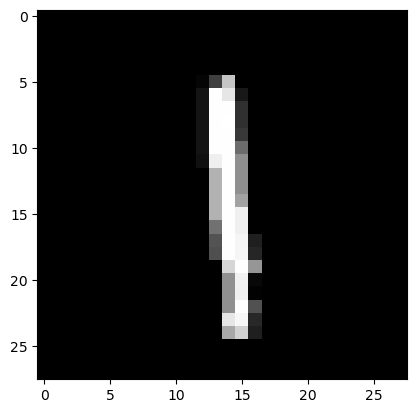

[2 0 4 5]
<class 'numpy.ndarray'>


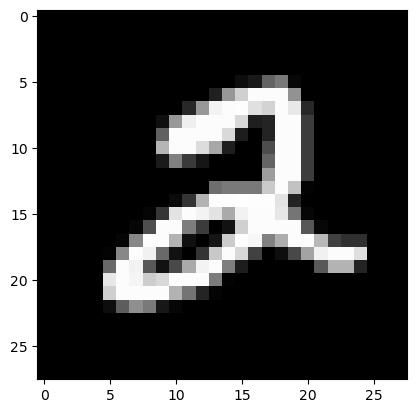

[4 1 5 3]
<class 'numpy.ndarray'>


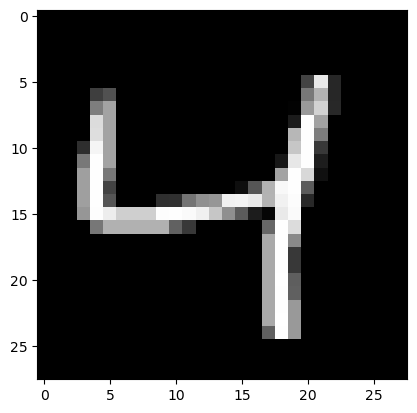

In [380]:
X_train, y_train = data["x_train"][0:12].reshape((-1,784)) / 255, data["y_train"][0:12]
print(y_train.shape)
train_loader = DataLoader(X_train, y_train, 4, shuffle=True)
for X, y in train_loader:
    print(y)
    im = X[0].reshape((28,28))
    print(type(im))
    plt.imshow(im, cmap='grey')
    plt.show()
    continue

In [381]:
def one_hot_encode(array, num_c):
    one_hot = np.zeros(shape=(array.size, num_c))
    for idx, i in enumerate(array):
        one_hot[idx, i] = 1

    return one_hot

In [382]:
nn = Sequential([Affine(784, 100), Relu(), Affine(100, 200), Relu(), Affine(200, 10), SoftMax()])
nn.params

[parameter shape: (784, 100), size: 78400,
 parameter shape: (100,), size: 100,
 parameter shape: (100, 200), size: 20000,
 parameter shape: (200,), size: 200,
 parameter shape: (200, 10), size: 2000,
 parameter shape: (10,), size: 10]

In [383]:
class MultiAverageMeter():
    def __init__(self):
        self._metrics = {}
        self._counts = {}
    
    def update(self, metric, mean, n=1):
        if metric in self._metrics.keys():
            k = self._counts[metric]
            self._metrics[metric] += n*(mean - self._metrics[metric])/(k+n)
            self._counts[metric] += n
        else:
            self._metrics[metric] = mean
            self._counts[metric] = n
    
    def get_metric(self, metric):
        if metric in self._metrics:
            return  self._metrics[metric]
        raise KeyError(f'{metric} not found')
    
    def dump_metrics(self):
        return self._metrics

    def reset(self, metric=None):
        if metric is None:
            self._metrics = {}
            self._counts = {}
        else:
            del self._metrics[metric]
            del self._counts[metric]

    def get_log_str(self, metrics=None):
        log_str = ''
        metrics = self._metrics.keys() if metrics is None else metrics
        for metric in metrics:
            if metric not in self._metrics:
                continue
            log_str += f'{metric} : {self._metrics[metric]:.4f} '
        return log_str

    def __getitem__(self, key):  
        return self.get_metric(key)
    
    def __contains__(self, key): 
        return key in self._metrics
    
    def __iter__(self):          
        return iter(self._metrics)
    
    def items(self):            
        return self._metrics.items()
    
    def __len__(self):           
        return len(self._metrics)
    
    def __repr__(self):          
        return f"MultiAverageMeter({self._metrics})"

In [384]:
def get_wandb_run(wandb_config:dict, api_key:str|None=None):
    if api_key is None:
        load_dotenv()
        api_key = os.getenv("WANDB_API_KEY")
    assert api_key is not None, 'api key required'

    wandb.login(key=api_key)
    return wandb.init(**wandb_config)


class WandBLogger():
    def __init__(self, meter:MultiAverageMeter, wandb_config:dict, api_key:str|None=None):
        self._meter = meter
        self._wandb_run = get_wandb_run(wandb_config, api_key)
        self._mode = 'train'

    def eval(self):
        self._mode = 'eval'

    def train(self):
        self._mode = 'train'

    def test(self):
        self._mode = 'test'

    def log_epoch(self, epoch):
        metrics = {}
        for name, val in self._meter.items():
            metrics[name + f'/{self._mode}'] = val
        metrics = metrics | self.get_system_metrics()
        self._wandb_run.log(metrics, step=epoch)

    def get_system_metrics(self):
        metrics = {
            'sys/ram_gb' : proc.memory_info().rss / 1_073_741_824
        }
        return metrics
    
    def finish(self):
        self._wandb_run.finish()

In [385]:
wandb_config = {'project': 'torch from scratch testing',
                'name': 'mnist_test_1',
                'config': {'optimiser':'adam', 'lr':0.05},
                'group': 'mnist tests',}

In [388]:
def train_test_step(meter:MultiAverageMeter, train, nn, loader, loss_fn, optimiser):
    start = time.time()
    if train:
        nn.train()
    else:
        nn.eval()

    for X, y in loader:

        nn.zero_grad()
        out = nn(Tensor(X))
        loss = loss_fn(out, y)
        if train:
            loss.backward()
            optimiser.step()
        
        preds = np.argmax(out.item(), axis=-1)
        acc = np.sum(preds == y) / preds.size 
        
        meter.update('CE', loss.item(), y.shape[0])
        meter.update('accuracy', acc, y.shape[0])
    end = time.time()
    meter.update('speed/epoch_sec', end - start)
    meter.update('speed/samples_per_sec', len(loader) / (end - start))
    return meter.get_log_str()

def train_nn(epochs):

    meter = MultiAverageMeter()
    wandb_logger = WandBLogger(meter, wandb_config)

    X_train, y_train = data["x_train"].reshape((-1,784)) / 255, data["y_train"]
    X_test, y_test = data["x_test"].reshape((-1,784)) / 255, data["y_test"]

    train_loader = DataLoader(X_train, y_train, 256, shuffle=True)
    test_loader = DataLoader(X_test, y_test, 256, shuffle=False)

    nn = Sequential([Affine(784, 100), Relu(), Affine(100, 200), Relu(), Affine(200, 10)])
    loss_fn = SoftMaxCrossEntropy()
    # optimiser = Adam(nn.params)
    optimiser = SGD(nn.params, lr=0.05)

    for t in range(epochs):
        print(f'epoch: {t}')
        wandb_logger.train()
        meter.reset()
        log = train_test_step(meter, True, nn, train_loader, loss_fn, optimiser)
        print('train: ' + log)
        wandb_logger.log_epoch(t)

        wandb_logger.eval()
        meter.reset()
        log = train_test_step(meter, False, nn, test_loader, loss_fn, optimiser)
        print('test: ' + log)
        wandb_logger.log_epoch(t)

    wandb_logger.finish()   


In [389]:
train_nn(40)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nikiw\_netrc


epoch: 0
train: CE : 0.6605 accuracy : 0.8229 speed/epoch_sec : 0.4172 speed/samples_per_sec : 563.3391 
test: CE : 0.3445 accuracy : 0.9037 speed/epoch_sec : 0.0331 speed/samples_per_sec : 1206.9853 
epoch: 1
train: CE : 0.3117 accuracy : 0.9101 speed/epoch_sec : 0.4131 speed/samples_per_sec : 568.8045 
test: CE : 0.2751 accuracy : 0.9216 speed/epoch_sec : 0.0306 speed/samples_per_sec : 1306.5045 
epoch: 2
train: CE : 0.2595 accuracy : 0.9252 speed/epoch_sec : 0.4199 speed/samples_per_sec : 559.6600 
test: CE : 0.2494 accuracy : 0.9245 speed/epoch_sec : 0.0457 speed/samples_per_sec : 875.7153 
epoch: 3
train: CE : 0.2281 accuracy : 0.9342 speed/epoch_sec : 0.4154 speed/samples_per_sec : 565.7243 
test: CE : 0.2223 accuracy : 0.9343 speed/epoch_sec : 0.0268 speed/samples_per_sec : 1492.3561 
epoch: 4
train: CE : 0.2038 accuracy : 0.9418 speed/epoch_sec : 0.4205 speed/samples_per_sec : 558.9196 
test: CE : 0.1936 accuracy : 0.9436 speed/epoch_sec : 0.0357 speed/samples_per_sec : 1121.10

CE/eval,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CE/train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/eval,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇██████████████
accuracy/train,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
speed/epoch_sec/eval,▃▂█▁▄▂▄▄▃▅▆▅▄▆▆▅▃▅▄▅▃▅▅▅▆▅▆▄▆▄▇▆▆▅▇▅▇▇█▇
speed/epoch_sec/train,▁▁▁▁▁▂▂▂▂▃▄▄▄▄▅▄▄▄▅▆▄▅▅▅▆▆▆▆▆▆▅▆▇▆▇█▇▇█▇
speed/samples_per_sec/eval,▅▆▁█▄▆▄▄▅▃▂▃▄▂▂▃▅▃▄▃▅▃▃▃▂▃▃▄▂▄▂▃▂▃▂▃▁▂▁▁
speed/samples_per_sec/train,█████▆▇▆▇▅▅▅▄▄▃▅▅▄▄▃▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▂▁▁
sys/ram_gb,▁▂▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▄▅▆▆▆▆▆▆▆▇▇▇▇▇███
CE/eval,0.07913
CE/train,0.04081
